<a href="https://colab.research.google.com/github/dkaratzas/DL2022-23/blob/main/Problems%207%20-%20Autoencoders/P7_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%207%20-%20Autoencoders/P7_Autoencoders.ipynb)

Marino Oliveros Blanco NIU:1668563

# Autoencoders

In this notebook we will explore three different types of autoencoder architectures: Simple MLP Autoencoder, Convolutional Autoencoder and Variational Autoencoder (VAE). We will also see how we can use VAEs to generate new data.

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# Setting up

In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

100%|██████████| 9912422/9912422 [00:00<00:00, 59046594.88it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112162679.47it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21784942.44it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21747178.96it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Simple Autoencoder

We will define a simple MLP Autoencoder

In [5]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [7]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch : 1/10, Train loss = 0.049517
epoch : 1/10, Test loss = 0.024767


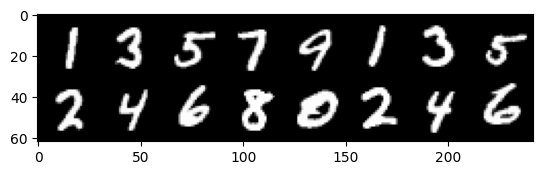

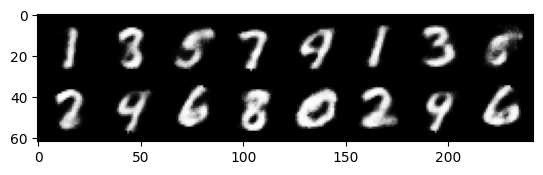

epoch : 2/10, Train loss = 0.020490
epoch : 2/10, Test loss = 0.016753


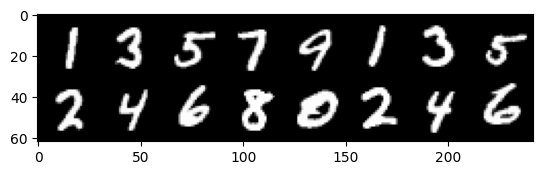

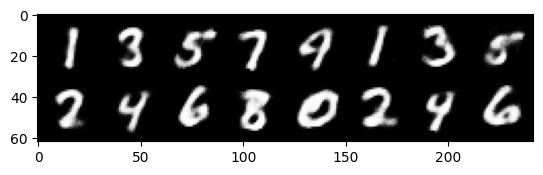

epoch : 3/10, Train loss = 0.015160
epoch : 3/10, Test loss = 0.013088


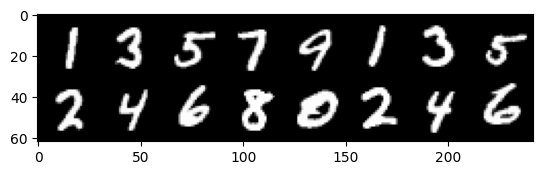

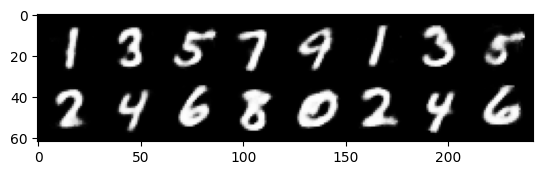

epoch : 4/10, Train loss = 0.012374
epoch : 4/10, Test loss = 0.011044


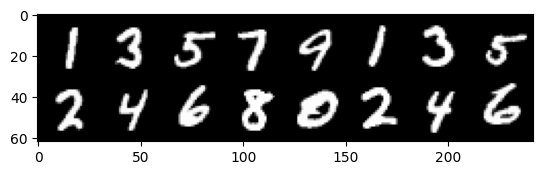

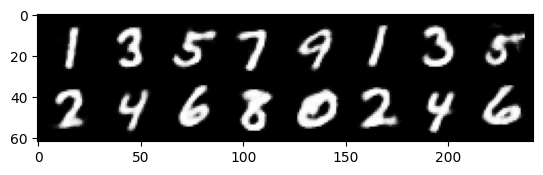

epoch : 5/10, Train loss = 0.010753
epoch : 5/10, Test loss = 0.009898


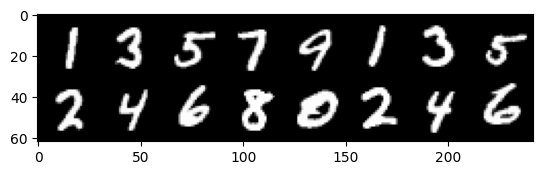

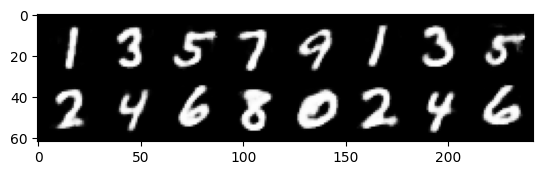

epoch : 6/10, Train loss = 0.009628
epoch : 6/10, Test loss = 0.008859


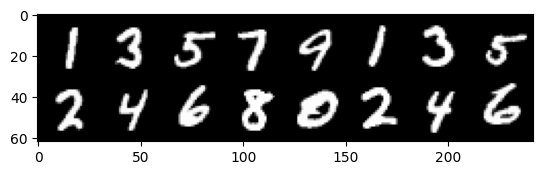

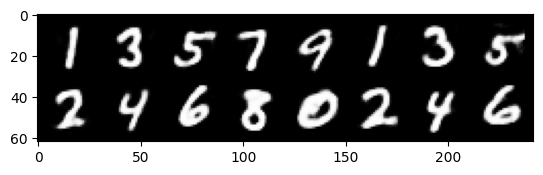

epoch : 7/10, Train loss = 0.008728
epoch : 7/10, Test loss = 0.008072


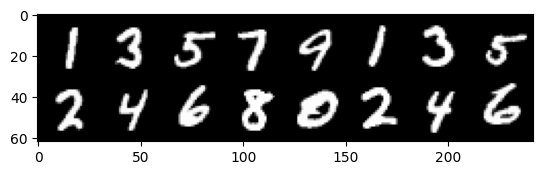

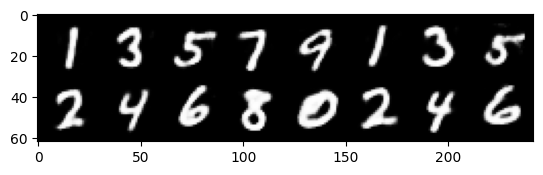

epoch : 8/10, Train loss = 0.008012
epoch : 8/10, Test loss = 0.007476


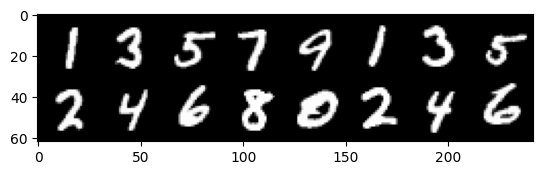

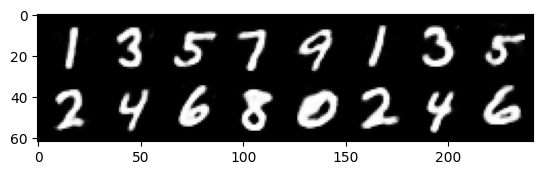

epoch : 9/10, Train loss = 0.007401
epoch : 9/10, Test loss = 0.006896


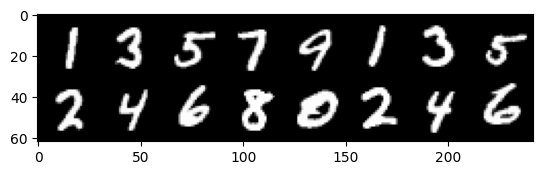

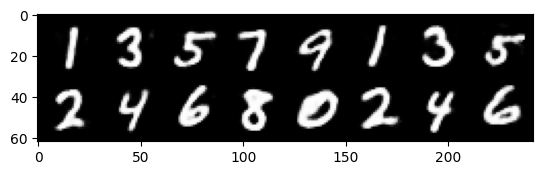

epoch : 10/10, Train loss = 0.006917
epoch : 10/10, Test loss = 0.006548


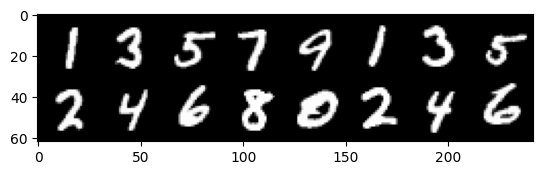

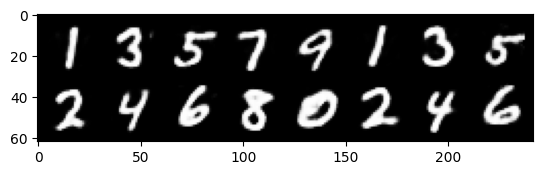

In [8]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True)

# Convolutional Autoencoder

We will now build a convolutional Autoencoder. Below you can find an incomplete implementation of one (only the encoder part)...

In [9]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(

            # THIS PART IS MISSING...

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<span style="color:blue">

**Exercise 1**: Build the decoder for the convolutional autoencoder model above and train it using the same functions and hyper-parameters as defined above.

> Hint: Use only deconvolutions (design an non-symmetric architecture) so that you do not have to store indices for the unpooling layers. Have a look at `ConvTranspose2d()` https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    
> Hint: Remember that to calculate the new activation map's size while deconvolving you should use: $𝑛^{[𝑙]} =(𝑛^{[𝑙−1]}−1) 𝑠 − 2𝑝 + 𝑓$
    
</span>

epoch : 1/10, Train loss = 0.112535
epoch : 1/10, Test loss = 0.086209


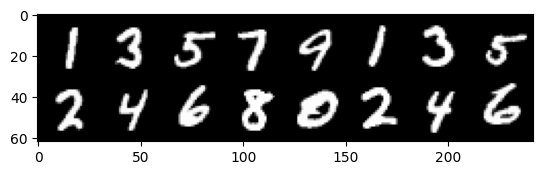

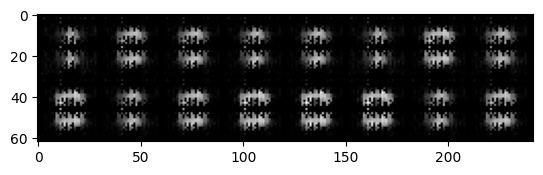

epoch : 2/10, Train loss = 0.067599
epoch : 2/10, Test loss = 0.053583


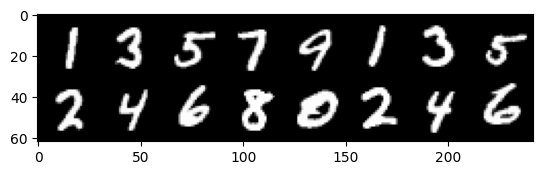

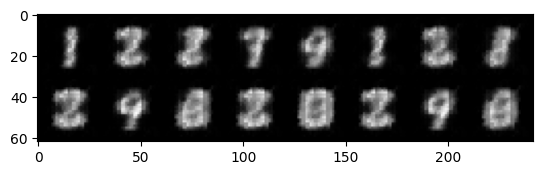

epoch : 3/10, Train loss = 0.048902
epoch : 3/10, Test loss = 0.045011


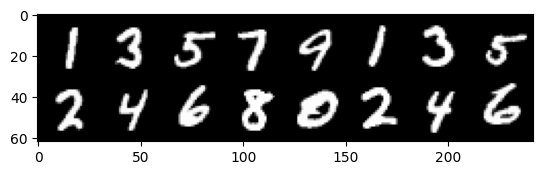

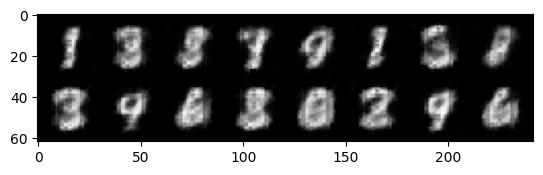

epoch : 4/10, Train loss = 0.043007
epoch : 4/10, Test loss = 0.040462


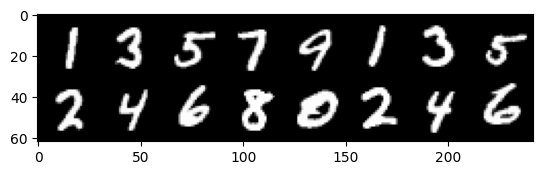

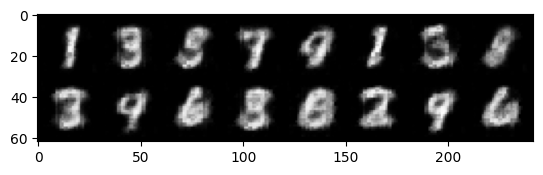

epoch : 5/10, Train loss = 0.039570
epoch : 5/10, Test loss = 0.038031


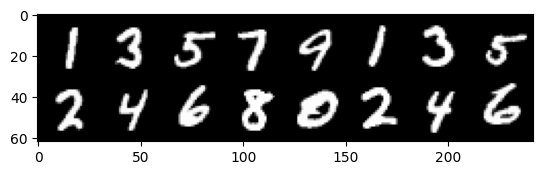

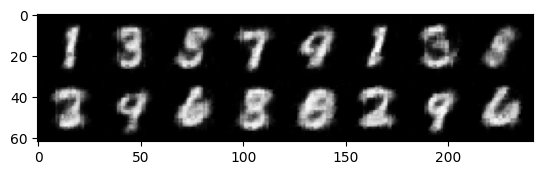

epoch : 6/10, Train loss = 0.037785
epoch : 6/10, Test loss = 0.036648


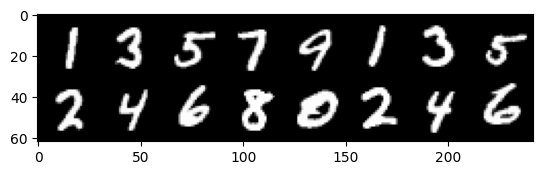

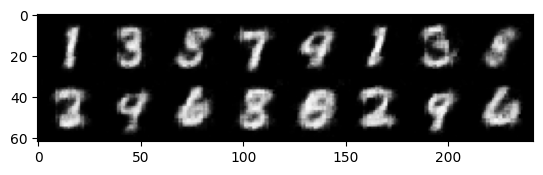

epoch : 7/10, Train loss = 0.036721
epoch : 7/10, Test loss = 0.035754


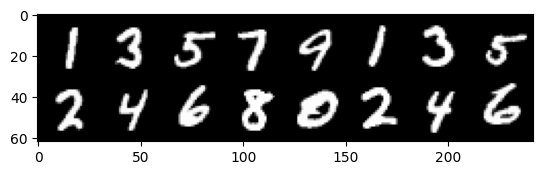

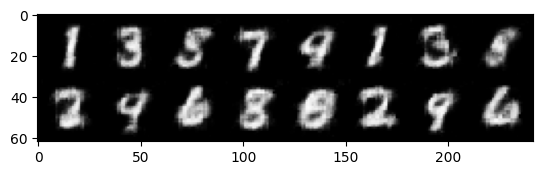

epoch : 8/10, Train loss = 0.035819
epoch : 8/10, Test loss = 0.035027


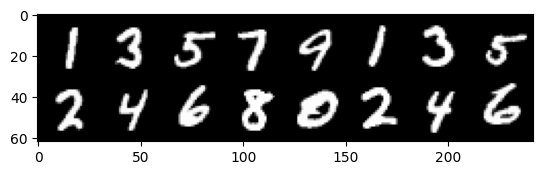

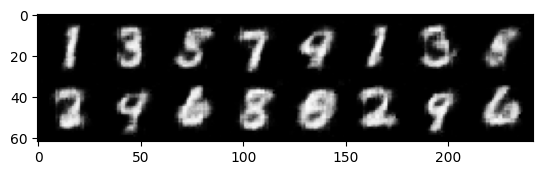

epoch : 9/10, Train loss = 0.035163
epoch : 9/10, Test loss = 0.034440


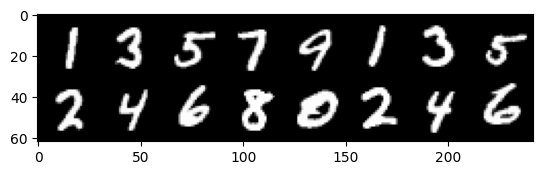

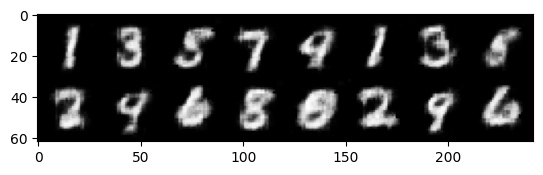

epoch : 10/10, Train loss = 0.034586
epoch : 10/10, Test loss = 0.033908


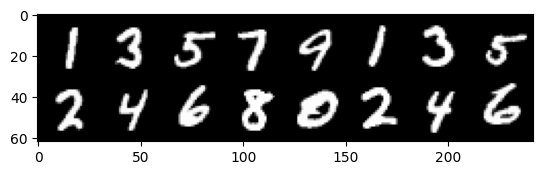

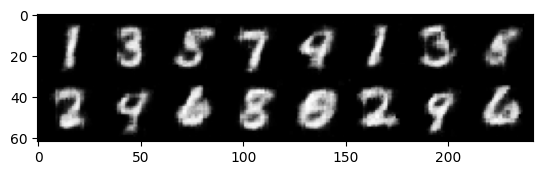

In [10]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


conv_ae_model = ConvAE().to(device)
conv_ae_optimizer = torch.optim.Adam(conv_ae_model.parameters(), lr=1e-3)
conv_ae_criterion = nn.MSELoss()

epochs = 10
for epoch in range(epochs):
    train(conv_ae_model, train_loader, conv_ae_optimizer, conv_ae_criterion)
    test(conv_ae_model, test_loader, conv_ae_criterion)

<span style="color:blue">

**Exercise 2 (HOMEWORK)**: Rebuild the network, but this time do a symmetric design for the decoder (using unpooling as required) and train it using the same functions and hyper-parameters as defined above.

> Hint: Have a look at `MaxUnpool2d()` https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html
    
</span>

epoch : 1/10, Train loss = 0.131002
epoch : 1/10, Test loss = 0.100184


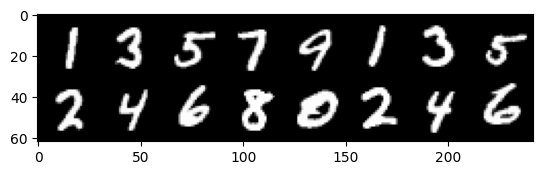

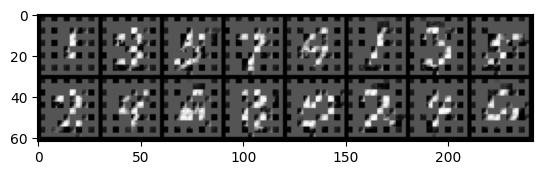

epoch : 2/10, Train loss = 0.085122
epoch : 2/10, Test loss = 0.073282


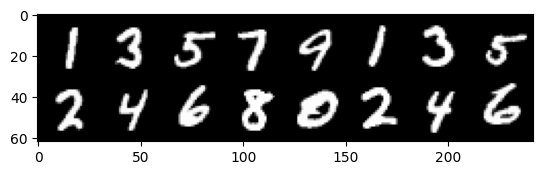

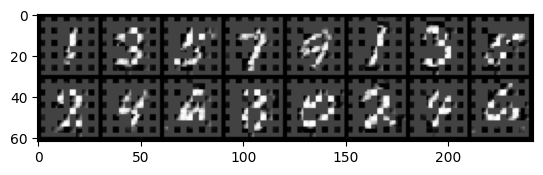

epoch : 3/10, Train loss = 0.064161
epoch : 3/10, Test loss = 0.056845


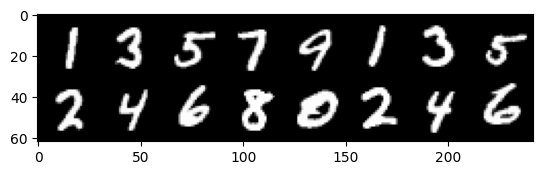

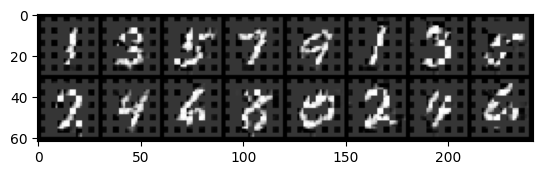

epoch : 4/10, Train loss = 0.050580
epoch : 4/10, Test loss = 0.046012


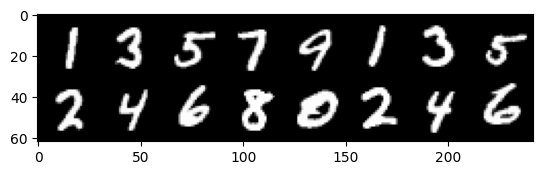

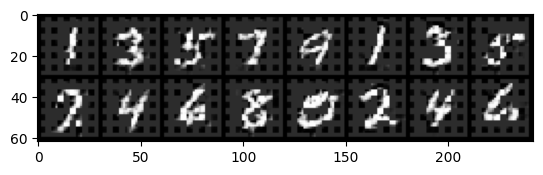

epoch : 5/10, Train loss = 0.042621
epoch : 5/10, Test loss = 0.040055


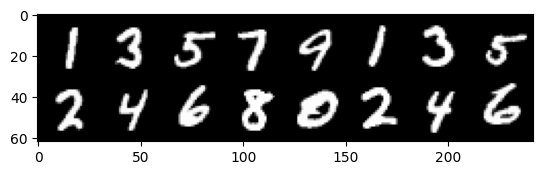

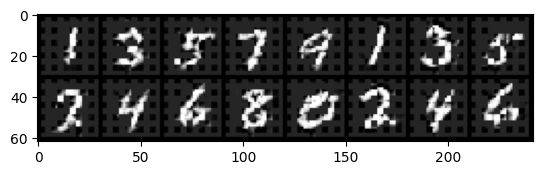

epoch : 6/10, Train loss = 0.037902
epoch : 6/10, Test loss = 0.036308


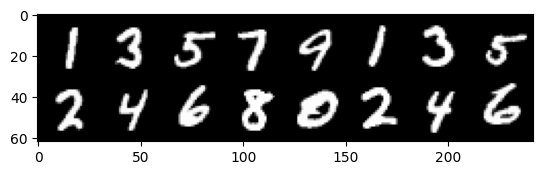

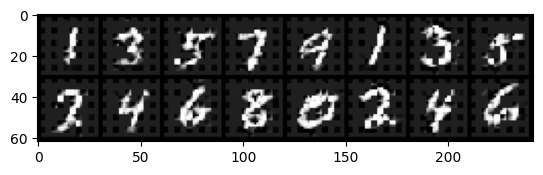

epoch : 7/10, Train loss = 0.034860
epoch : 7/10, Test loss = 0.033832


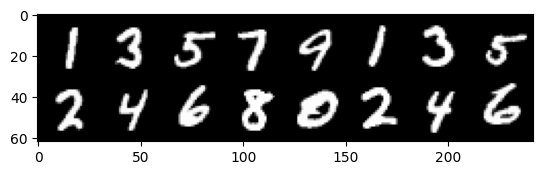

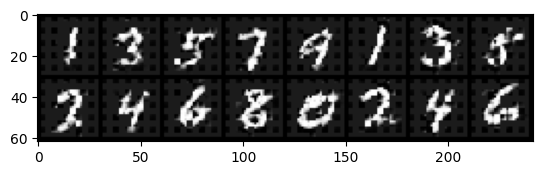

epoch : 8/10, Train loss = 0.032951
epoch : 8/10, Test loss = 0.031921


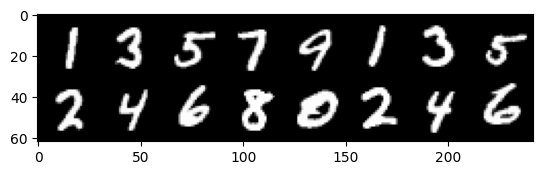

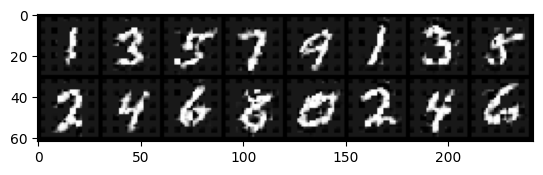

epoch : 9/10, Train loss = 0.030460
epoch : 9/10, Test loss = 0.029677


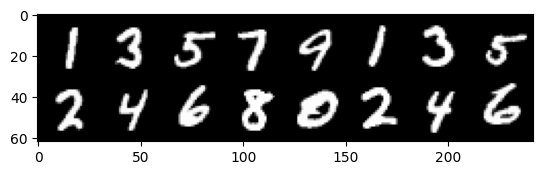

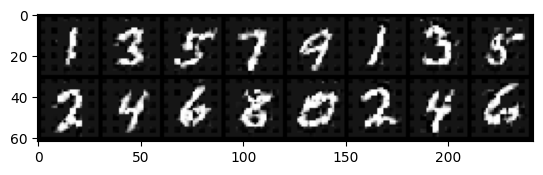

epoch : 10/10, Train loss = 0.028927
epoch : 10/10, Test loss = 0.028527


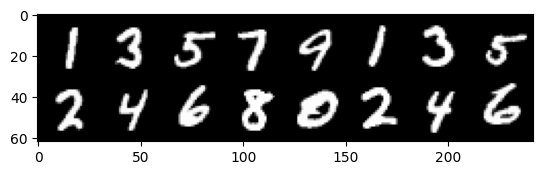

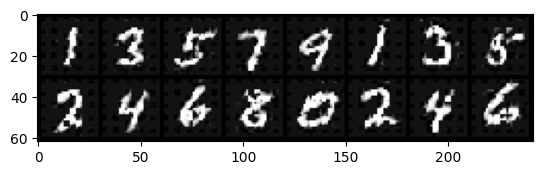

In [11]:
class SymmetricConvAE(nn.Module):
    def __init__(self):
        super(SymmetricConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1, return_indices=True))

        self.decoder = nn.Sequential(
            nn.MaxUnpool2d(2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8,out_channels=16,kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=3, padding=1),
            nn.Sigmoid()
        )

    # To solve the problem of unpacking many value
    def forward(self, x):
        listOfindices = []
        for layer in self.encoder:
            if isinstance(layer, nn.MaxPool2d):
                x, indices = layer(x)
                listOfindices.append(indices)
            else:
                x = layer(x)
        id = 1
        for layer in self.decoder:
            if isinstance(layer, nn.MaxUnpool2d):
                x = layer(x, listOfindices[-id])
                id += 1
            else:
                x = layer(x)
        return x


conv_ae_model = SymmetricConvAE().to(device)
conv_ae_optimizer = torch.optim.Adam(conv_ae_model.parameters(), lr=1e-3)
conv_ae_criterion = nn.MSELoss()

epochs = 10
for epoch in range(epochs):
    train(conv_ae_model, train_loader, conv_ae_optimizer, conv_ae_criterion)
    test(conv_ae_model, test_loader, conv_ae_criterion)

# Variational Autoencoders (VAEs)

Below we define a variational autoencoder. It takes a vector of 784 elements, and maps it into a mean and a `logvar` of size 20.

Note that `logvar` corresponds to $ln(\sigma^2)$.

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In the case of the VAE, we need to define our own loss function, as we need to combine the reconstruction loss, with the regularisation term (Gaussian prior for the embedding distribution).

> *NOTE: You will see that we use an MSE loss as a reconstruction loss, instead of the negative log likelihood that we should be using... this actually makes sense. We have designed this model so that the output of the decoder is the image - the pixel values (means) and not distributions over the pixel values (e.g. means and variances of a Gaussian).*

> *This is typical in VAE implementations; the output of the decoder is actually the mean $\mu_{x|z}$ (let's just call it $\mu$) and we usually assumes a unitary covariance. So in that case we have: $log(P(x|z))=-{\frac 1 2}[log(|Σ|)+k log(2\pi)+(x−\mu)^T(x−\mu)]$*

> *This comes from taking the log of the probability density function of a multivariate Gaussian distribution. Now you can see that since the first two terms are constant with respect to $\mu$, the optimization problem is equivalent to maximizing $-{\frac 1 2}(x−\mu)^T(x−\mu)$ which is the just the L2 loss between $x$ and $\mu$. Finally the expectation is just approximated by averaging.*

In [13]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    # Reconstruction term
    recLoss = nn.MSELoss(reduction='sum')

    # KL divergence regularisation term
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [14]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

In [15]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

<ipython-input-12-f0bbe4192b33>:19: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  eps = torch.cuda.FloatTensor(std.size()).normal_()


epoch : 1/10, Train loss = 5837.905987
epoch : 1/10, Test loss = 1177.633751


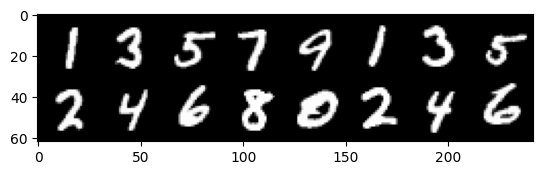

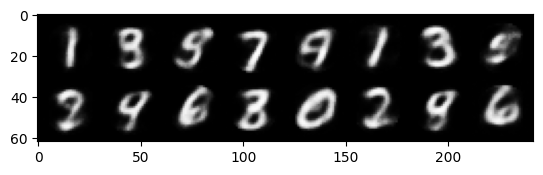

epoch : 2/10, Train loss = 4505.028872
epoch : 2/10, Test loss = 1073.560540


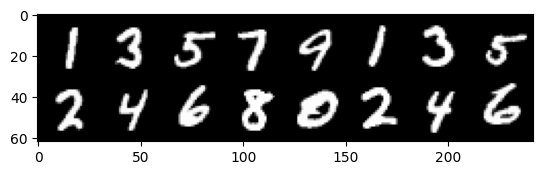

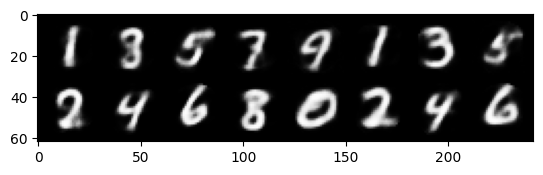

epoch : 3/10, Train loss = 4250.746598
epoch : 3/10, Test loss = 1041.535029


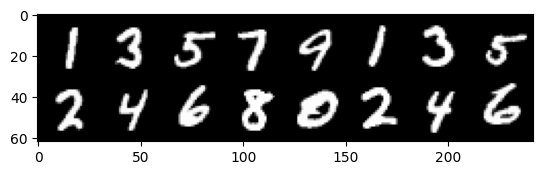

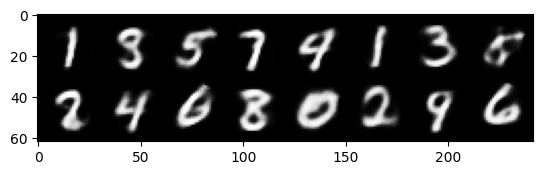

epoch : 4/10, Train loss = 4130.744540
epoch : 4/10, Test loss = 1015.054735


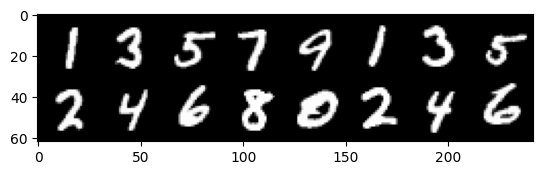

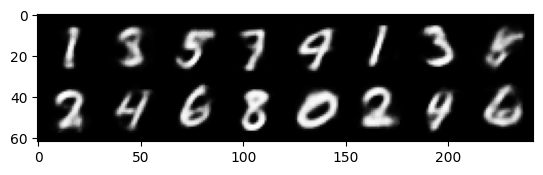

epoch : 5/10, Train loss = 4061.131680
epoch : 5/10, Test loss = 1003.846725


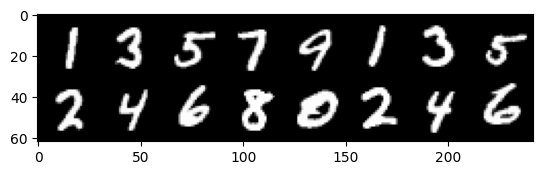

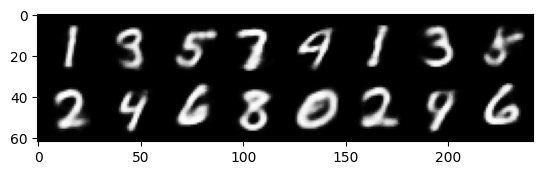

epoch : 6/10, Train loss = 4013.566509
epoch : 6/10, Test loss = 990.741236


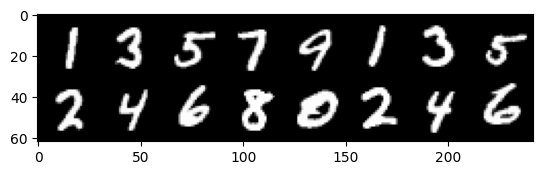

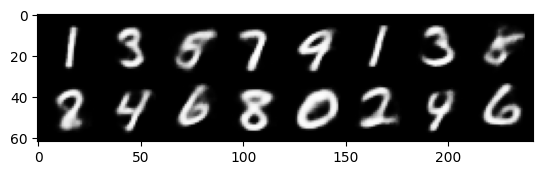

epoch : 7/10, Train loss = 3981.297148
epoch : 7/10, Test loss = 983.558362


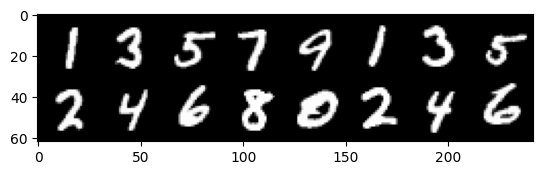

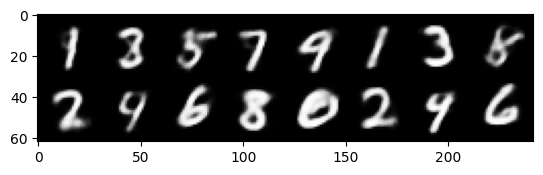

epoch : 8/10, Train loss = 3955.326310
epoch : 8/10, Test loss = 977.283310


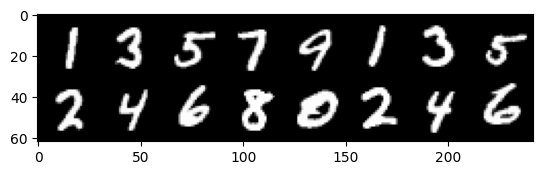

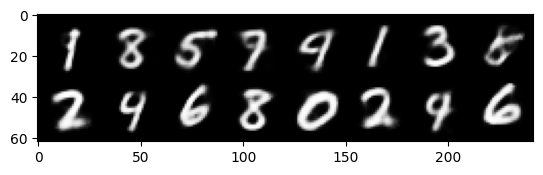

epoch : 9/10, Train loss = 3937.437577
epoch : 9/10, Test loss = 975.047731


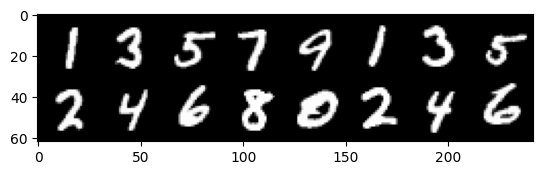

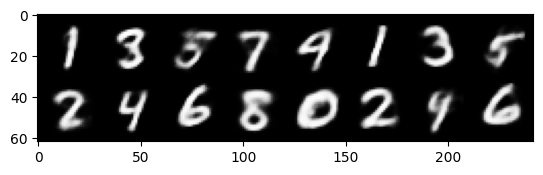

epoch : 10/10, Train loss = 3919.404091
epoch : 10/10, Test loss = 969.487857


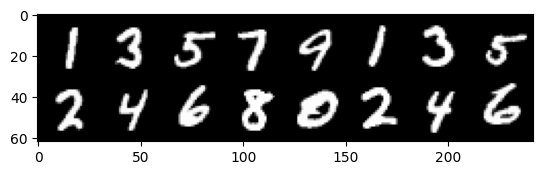

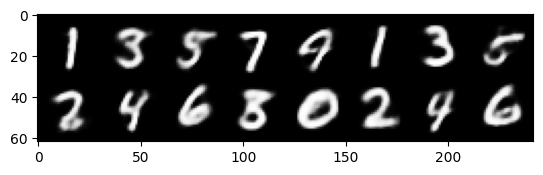

In [16]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion)

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them - you should be able to see an evolution from one to the other.

In [17]:
model.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        #img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        #img2 = img2.view(img2.size(0), -1).to(device)
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits

    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])

        inter_image = inter_image.view(1, 28, 28)

        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show()

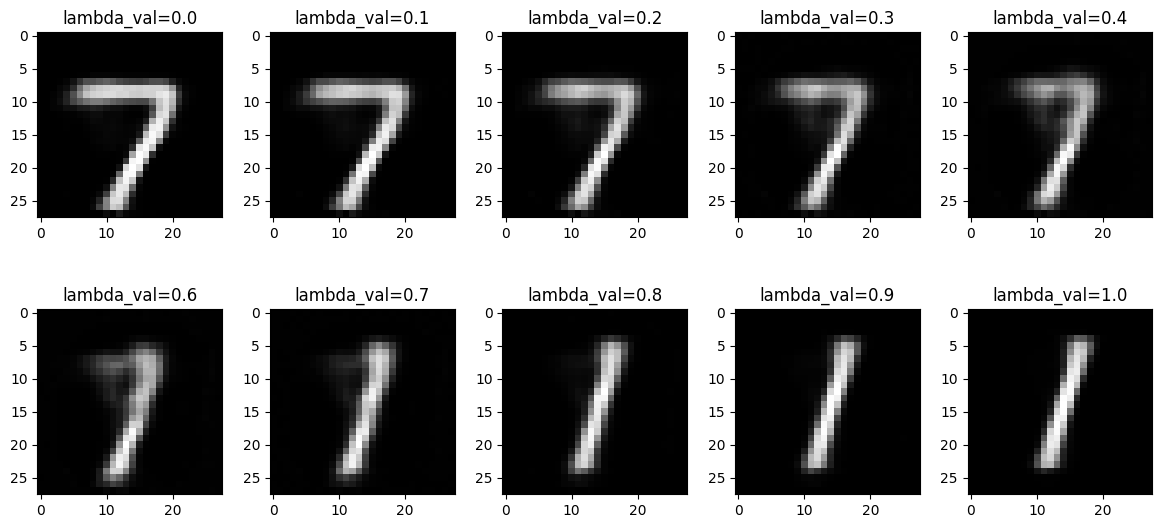

In [18]:
visualize_interpolation(model, test_loader, 7, 1)

<span style="color:blue">

**Exercise 3**: Use the already trained VAE model to generate 100 random new digits.

> Hint: Have a look at PyTorch's `randn()` https://pytorch.org/docs/stable/generated/torch.randn.html
    
</span>

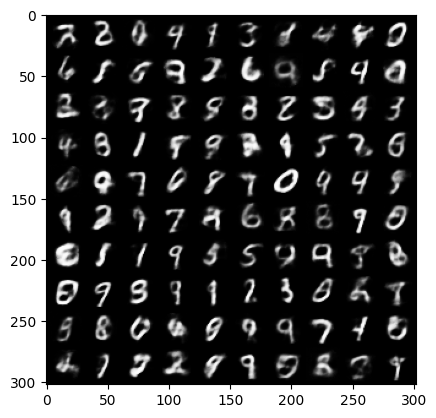

In [19]:
def show_image(img):
    img = img.cpu().clamp(0, 1)  # Move tensor to CPU and ensure range is between 0 and 1
    npimg = img.numpy()          # Convert to NumPy array
    npimg = np.transpose(npimg, (1, 2, 0))  # Change the order to (H, W, C)
    plt.imshow(npimg)
    plt.show()


def generate_random_digits(model, num_digits=100):
    with torch.no_grad():
        # Sample from a standard normal distribution
        z = torch.randn(num_digits, 20).to(device)
        # Decode the sampled latent vectors to generate new digits
        generated_digits = model.decode(z)

    return generated_digits

# Generate 100 random new digits
generated_digits = generate_random_digits(model, num_digits=100)

# Display the generated digits
show_image(make_grid(generated_digits.view(-1, 1, 28, 28), nrow=10, normalize=True))

<span style="color:blue">

**Exercise 4**: Modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and then complete the cell below to visualize the entire 2D latent space.
    
</span>

epoch : 1/10, Train loss = 6365.992455
epoch : 1/10, Test loss = 1388.650298


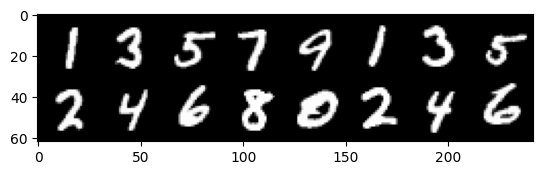

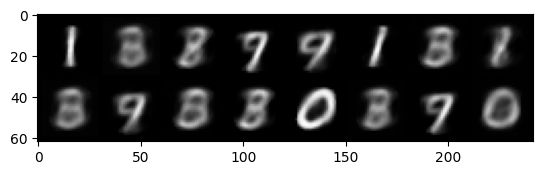

epoch : 2/10, Train loss = 5481.383688
epoch : 2/10, Test loss = 1349.059886


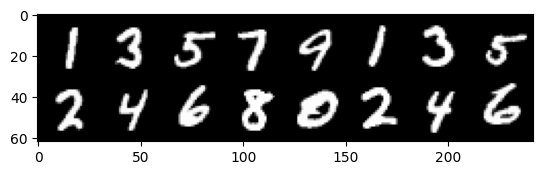

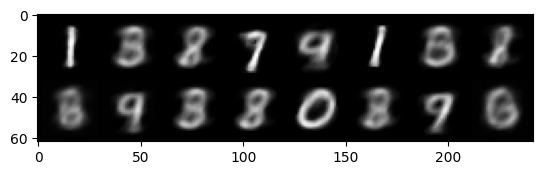

epoch : 3/10, Train loss = 5359.786118
epoch : 3/10, Test loss = 1328.244123


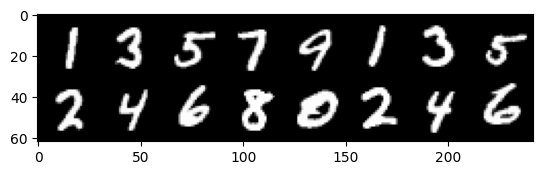

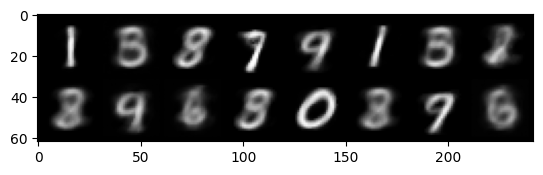

epoch : 4/10, Train loss = 5268.587422
epoch : 4/10, Test loss = 1306.564512


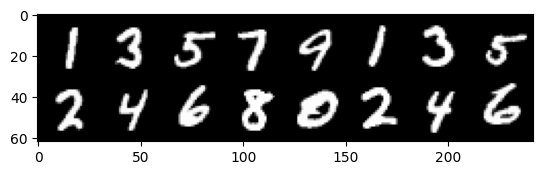

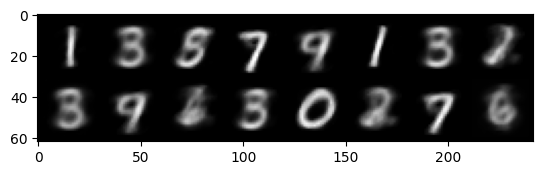

epoch : 5/10, Train loss = 5198.626764
epoch : 5/10, Test loss = 1290.069209


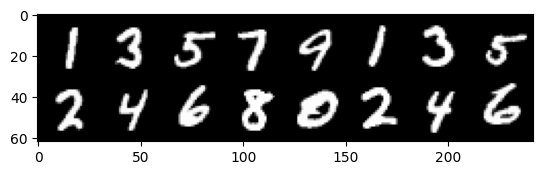

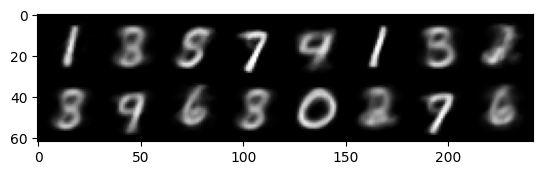

epoch : 6/10, Train loss = 5146.751922
epoch : 6/10, Test loss = 1278.991077


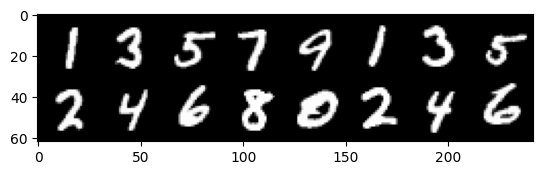

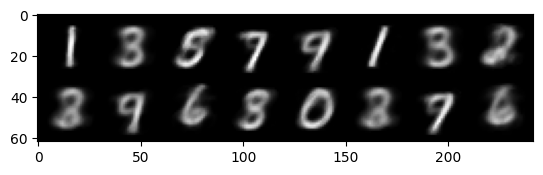

epoch : 7/10, Train loss = 5099.973691
epoch : 7/10, Test loss = 1273.361930


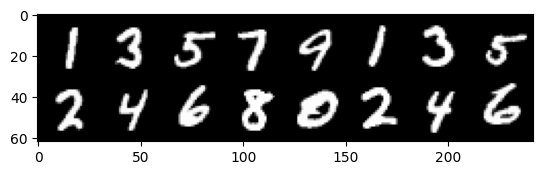

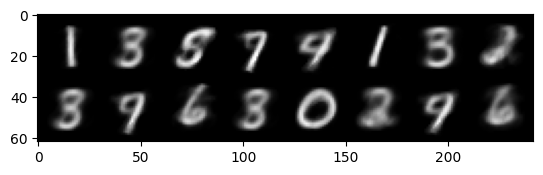

epoch : 8/10, Train loss = 5064.575920
epoch : 8/10, Test loss = 1268.370239


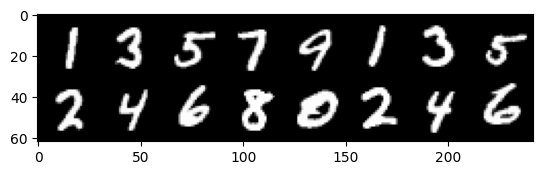

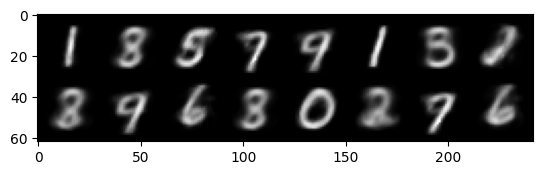

epoch : 9/10, Train loss = 5035.519573
epoch : 9/10, Test loss = 1256.639569


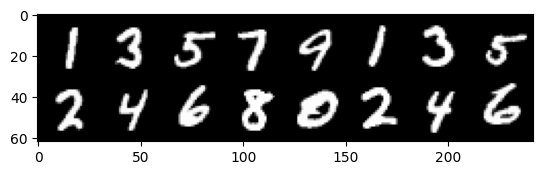

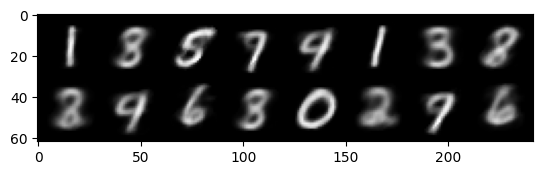

epoch : 10/10, Train loss = 5004.805376
epoch : 10/10, Test loss = 1253.372974


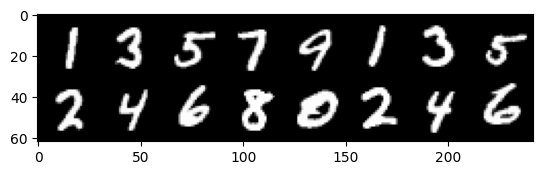

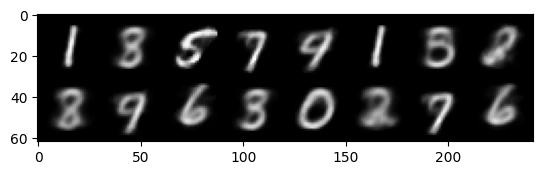

In [20]:
# Function to visualize images
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

# MODIFY VAE SO 2D LATENT SPACE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)  # Changed latent space size to 2
        self.fc22 = nn.Linear(400, 2)  # Changed latent space size to 2

        self.fc3 = nn.Linear(2, 400)  # Changed latent space size to 2
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


# TRAIN ON MNIST
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = loss_function

epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion)

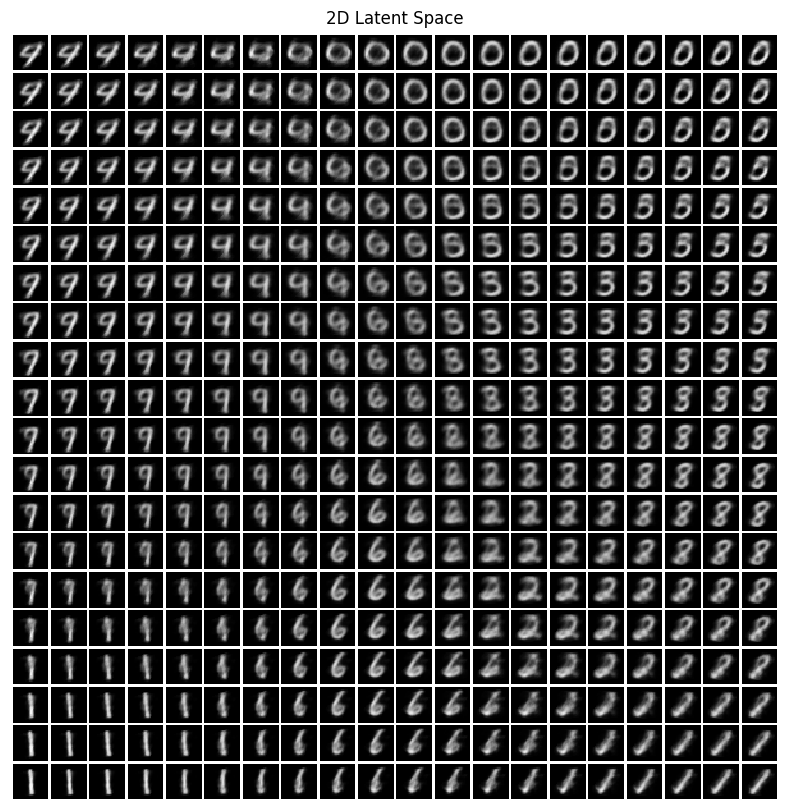

In [21]:
# DISPLAY LATENT SPACE
# Function to visualize images
def show_image2(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')


# Function to reconstruct images from the latent vectors
def reconstruct_images(model, latents):
    with torch.no_grad():
        reconstructed_images = model.decode(latents.to(device))
    return reconstructed_images.view(-1, 1, 28, 28)

# Generating latent space grid
latent_x = np.linspace(-1.5, 1.5, 20)
latent_y = np.linspace(-1.5, 1.5, 20)
latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
for i, lx in enumerate(latent_x):
    for j, ly in enumerate(latent_y):
        latents[j, i, 0] = lx
        latents[j, i, 1] = ly
latents = latents.view(-1, 2)  # Flatten grid into a batch

# Reconstruct images from the latent vectors
reconstructed_images = reconstruct_images(model, latents)

# Visualize reconstructed images
fig, ax = plt.subplots(figsize=(10, 10))
show_image2(torchvision.utils.make_grid(reconstructed_images, nrow=20, padding=2, pad_value=1))
plt.axis('off')
plt.title("2D Latent Space")
plt.show()

<span style="color:blue">

**Exercise 5**: Try both the simple encoder and the convolutional encoder with the FashionMNIST dataset, comment what you observe for both results.
    
</span>

In [22]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader_FMNIST = torch.utils.data.DataLoader(
    train_dataset_FMNIST, batch_size=128, shuffle=True, num_workers=2#, pin_memory=True
)

test_loader_FMNIST = torch.utils.data.DataLoader(
    test_dataset_FMNIST, batch_size=32, shuffle=False, num_workers=2
)

100%|██████████| 26421880/26421880 [00:03<00:00, 7744931.56it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 129624.62it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 495624.52it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6121995.18it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Simple encoder
epoch : 1/10, Train loss = 0.037584
epoch : 1/10, Test loss = 0.021459


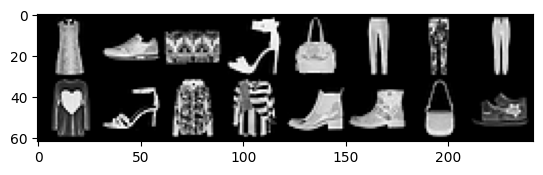

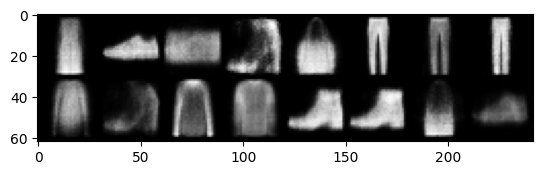

epoch : 2/10, Train loss = 0.019426
epoch : 2/10, Test loss = 0.018488


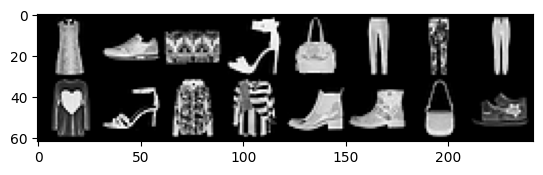

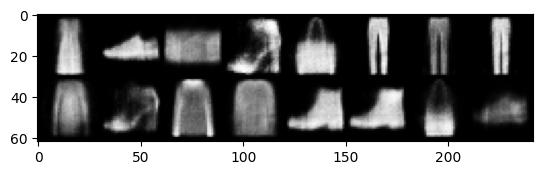

epoch : 3/10, Train loss = 0.016754
epoch : 3/10, Test loss = 0.015747


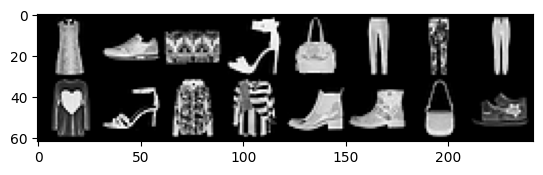

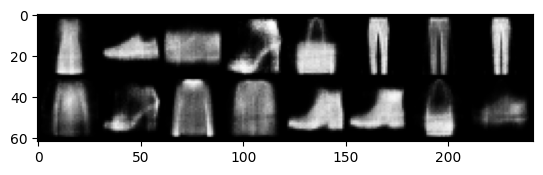

epoch : 4/10, Train loss = 0.015057
epoch : 4/10, Test loss = 0.014391


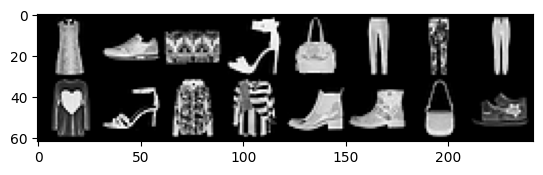

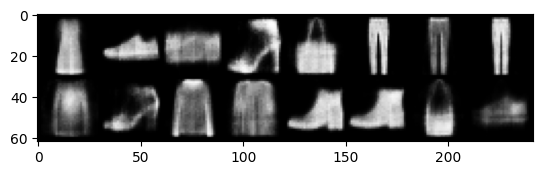

epoch : 5/10, Train loss = 0.013778
epoch : 5/10, Test loss = 0.013277


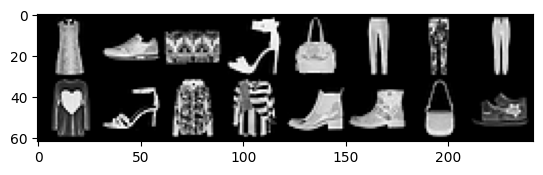

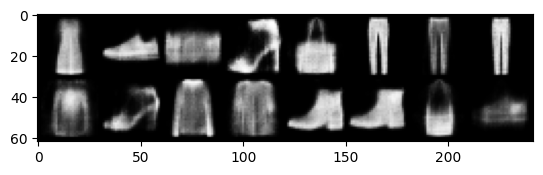

epoch : 6/10, Train loss = 0.012899
epoch : 6/10, Test loss = 0.012901


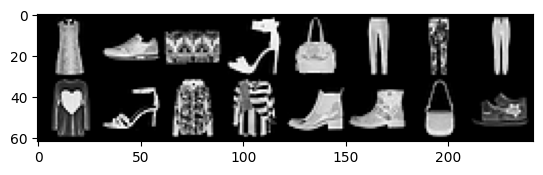

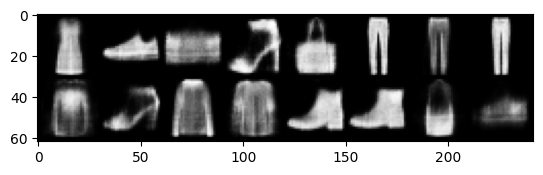

epoch : 7/10, Train loss = 0.012256
epoch : 7/10, Test loss = 0.012091


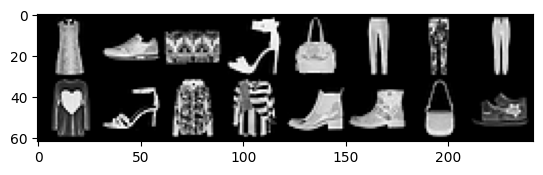

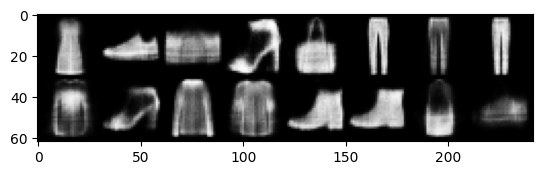

epoch : 8/10, Train loss = 0.011790
epoch : 8/10, Test loss = 0.011571


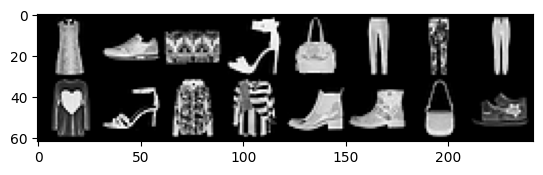

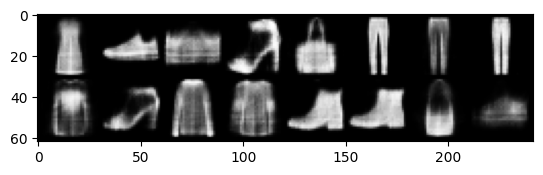

epoch : 9/10, Train loss = 0.011327
epoch : 9/10, Test loss = 0.011157


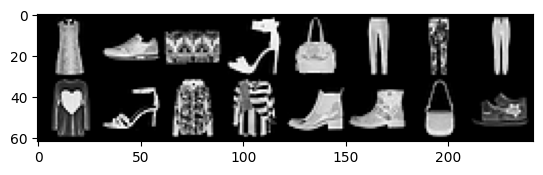

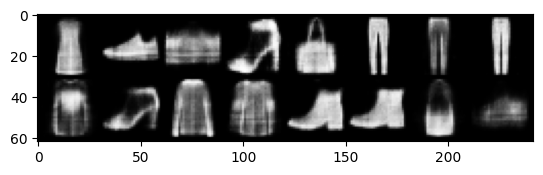

epoch : 10/10, Train loss = 0.010963
epoch : 10/10, Test loss = 0.010910


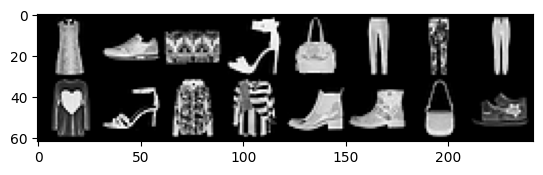

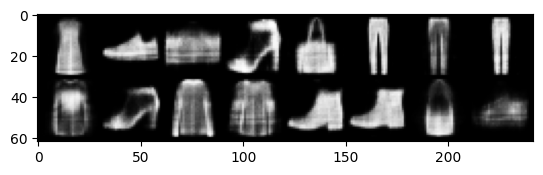

\Convolutional Autoencoder
epoch : 1/10, Train loss = 0.111689
epoch : 1/10, Test loss = 0.089900


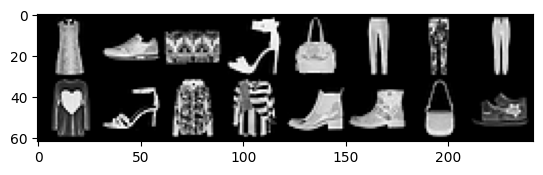

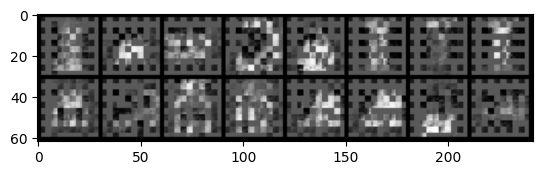

epoch : 2/10, Train loss = 0.083609
epoch : 2/10, Test loss = 0.078579


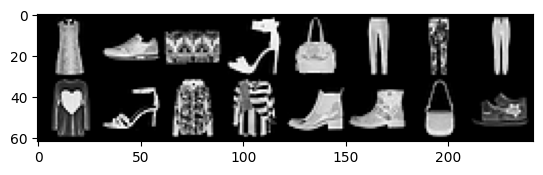

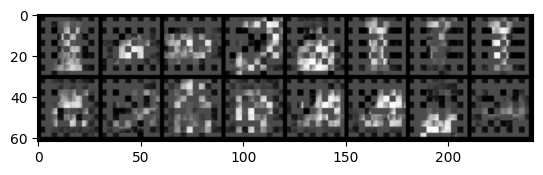

epoch : 3/10, Train loss = 0.076297
epoch : 3/10, Test loss = 0.074570


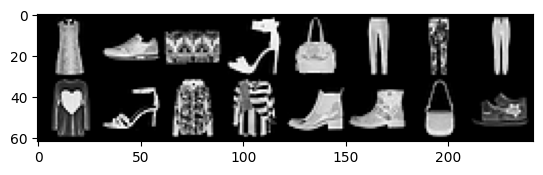

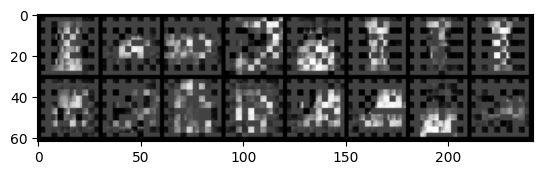

epoch : 4/10, Train loss = 0.072784
epoch : 4/10, Test loss = 0.070798


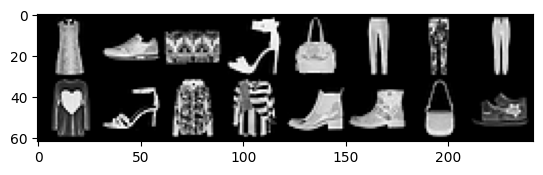

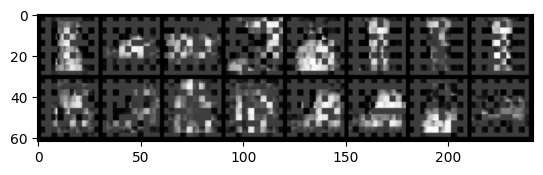

epoch : 5/10, Train loss = 0.068356
epoch : 5/10, Test loss = 0.065618


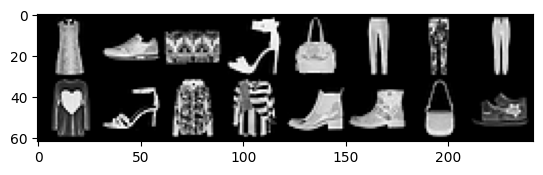

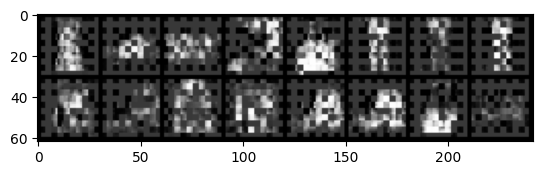

epoch : 6/10, Train loss = 0.064339
epoch : 6/10, Test loss = 0.063161


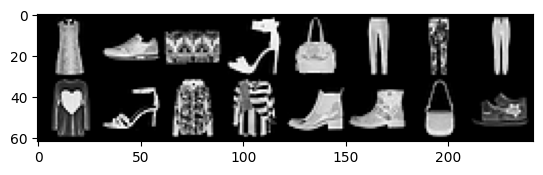

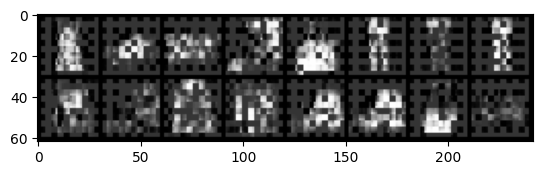

epoch : 7/10, Train loss = 0.062546
epoch : 7/10, Test loss = 0.061572


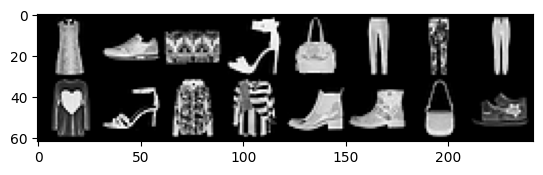

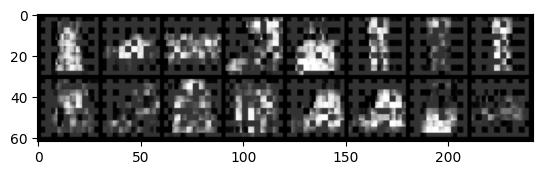

epoch : 8/10, Train loss = 0.060933
epoch : 8/10, Test loss = 0.060312


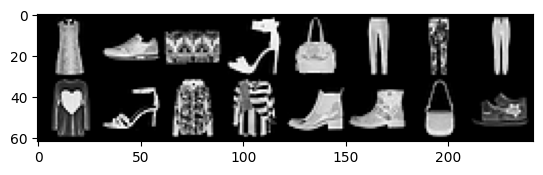

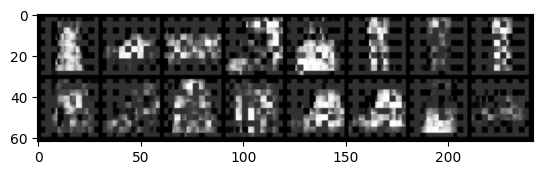

epoch : 9/10, Train loss = 0.059492
epoch : 9/10, Test loss = 0.058873


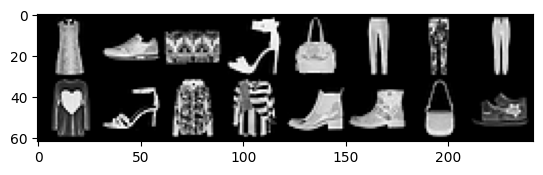

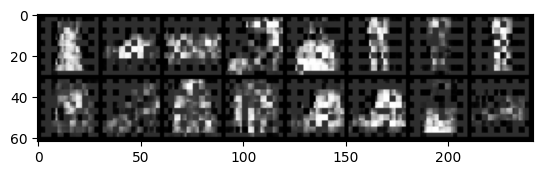

epoch : 10/10, Train loss = 0.058393
epoch : 10/10, Test loss = 0.057950


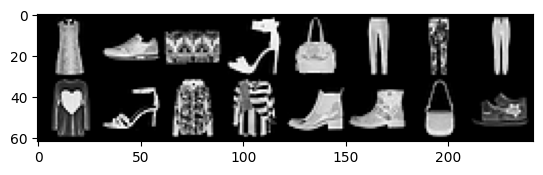

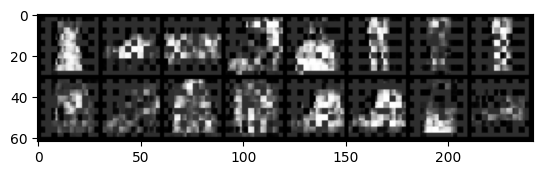

In [23]:
# Simple encoder
print("Simple encoder")
model = AE(input_size=784).to(device)
# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# mean-squared error loss
criterion = nn.MSELoss()
epochs=10
for epoch in range(epochs):
    train(model, train_loader_FMNIST, optimizer, criterion, reshape=True)
    test(model, test_loader_FMNIST, criterion, reshape=True)

# Convolutional Encoder
print("\nConvolutional Autoencoder")
conv_ae_model = SymmetricConvAE().to(device)
conv_ae_optimizer = torch.optim.Adam(conv_ae_model.parameters(), lr=1e-3)
conv_ae_criterion = nn.MSELoss()

epochs = 10
for epoch in range(epochs):
    train(conv_ae_model, train_loader_FMNIST, conv_ae_optimizer, conv_ae_criterion)
    test(conv_ae_model, test_loader_FMNIST, conv_ae_criterion)

💬 **Results:**

- Loss-wise the Simple encoder performs better (0.01 vs 0.05), but being the values so close we cannot really imply a strong performance difference. When compraring the reconstruction of images we can see a better/clearer representation on the ConvAE.